In [ ]:
# Install pydrive2
!pip install -U -q PyDrive2

# Authenticate and import libraries
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate user
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the file with title 'potato.zip'
file_list = drive.ListFile({'q': "title='potato.zip'"}).GetList()
if file_list:
    file_id = file_list[0]['id']
    file = drive.CreateFile({'id': file_id})
    file.GetContentFile('potato.zip')
    print("Download complete.")
else:
    print("File not found.")

# Unzip the file
!unzip -o 'potato.zip'

Download complete.
Archive:  potato.zip
   creating: Potato/
  inflating: Potato/.DS_Store        
  inflating: __MACOSX/Potato/._.DS_Store  
   creating: Potato/Training/
   creating: Potato/Validation/
   creating: Potato/Training/Potato___Early_blight/
  inflating: __MACOSX/Potato/Training/._Potato___Early_blight  
  inflating: Potato/Training/.DS_Store  
  inflating: __MACOSX/Potato/Training/._.DS_Store  
   creating: Potato/Training/Potato___Late_blight/
  inflating: __MACOSX/Potato/Training/._Potato___Late_blight  
   creating: Potato/Training/Potato___healthy/
  inflating: __MACOSX/Potato/Training/._Potato___healthy  
   creating: Potato/Validation/Potato___Early_blight/
  inflating: __MACOSX/Potato/Validation/._Potato___Early_blight  
  inflating: Potato/Validation/.DS_Store  
  inflating: __MACOSX/Potato/Validation/._.DS_Store  
   creating: Potato/Validation/Potato___Late_blight/
  inflating: __MACOSX/Potato/Validation/._Potato___Late_blight  
   creating: Potato/Validation/P

In [ ]:
import os

# Path to training & validation
base_dir = "."
train_dir = os.path.join(base_dir, "Potato/Training")
val_dir   = os.path.join(base_dir, "Potato/Validation")

print("Training subfolders:", os.listdir(train_dir))
print("Validation subfolders:", os.listdir(val_dir))

Training subfolders: ['Potato___Early_blight', '.DS_Store', 'Potato___Late_blight', 'Potato___healthy']
Validation subfolders: ['Potato___Early_blight', '.DS_Store', 'Potato___Late_blight', 'Potato___healthy']


In [ ]:
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tensorflow.keras import optimizers
print(tf.__version__)

2.19.0


In [ ]:
# Set basic parameters
IMG_SIZE = 224
BATCH_SIZE = 32

In [ ]:
# Create ImageDataGenerators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)


# Generate train and validation sets
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1721 images belonging to 3 classes.
Found 431 images belonging to 3 classes.


In [ ]:
# Inspect dataset structure
print("\n✅ Class indices:", train_gen.class_indices)
print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")



✅ Class indices: {'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}
Training samples: 1721
Validation samples: 431


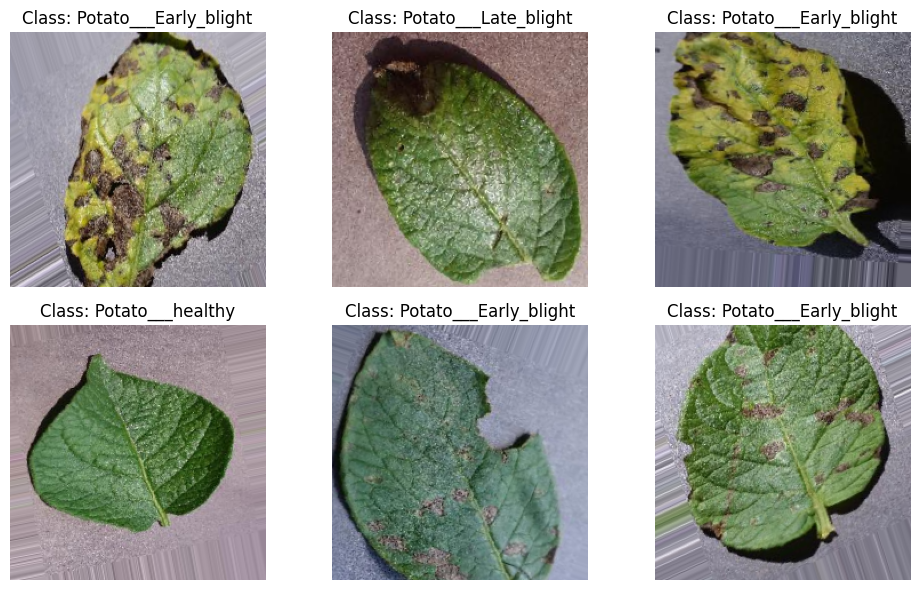

In [ ]:
# Preview random training images
x_batch, y_batch = next(train_gen)
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Class: {list(train_gen.class_indices.keys())[y_batch[i].argmax()]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

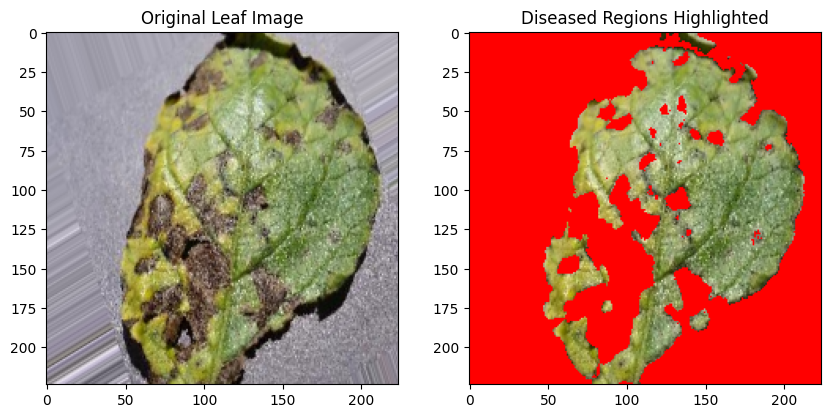

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Take one image from the batch
img = (x_batch[0] * 255).astype(np.uint8)

# Convert to HSV for color-based segmentation
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# Define green color range (healthy leaf)
lower_green = np.array([25, 40, 40])
upper_green = np.array([95, 255, 255])

# Mask healthy regions
mask_green = cv2.inRange(hsv, lower_green, upper_green)
mask_diseased = cv2.bitwise_not(mask_green)

# Highlight diseased areas in red
highlighted = img.copy()
highlighted[mask_diseased > 0] = [255, 0, 0]

# Display original vs highlighted
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Leaf Image")

plt.subplot(1,2,2)
plt.imshow(highlighted)
plt.title("Diseased Regions Highlighted")
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define image size and input shape
image_size = 224
input_shape = (image_size, image_size, 3)

# Build CNN Model
model = Sequential([
    # 1️⃣ Convolution + Pooling Block 1
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 2️⃣ Convolution + Pooling Block 2
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 3️⃣ Convolution + Pooling Block 3
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 4️⃣ Flatten and Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    # 5️⃣ Output layer (3 classes)
    Dense(3, activation='softmax')
])

# Compile Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,339 (84.86 MB)

 Trainable params: 22,245,891 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,339 (84.86 MB)

 Trainable params: 22,245,891 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

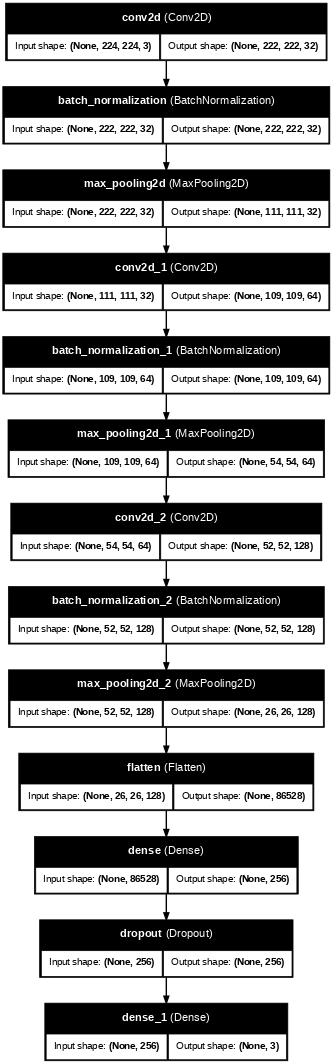

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=50)

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=2e-4),
    metrics=['acc']
)

In [ ]:
# Define training parameters
EPOCHS = 25
BATCH_SIZE = 32

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    verbose=1
)


Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8652 - loss: 4.5899

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 487ms/step - accuracy: 0.8653 - loss: 4.5995 - val_accuracy: 0.5383 - val_loss: 19.6020
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 401ms/step - accuracy: 0.8774 - loss: 4.8192 - val_accuracy: 0.4640 - val_loss: 112.1182
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 399ms/step - accuracy: 0.9042 - loss: 2.7440 - val_accuracy: 0.4640 - val_loss: 173.4807
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 402ms/step - accuracy: 0.8960 - loss: 1.2383 - val_accuracy: 0.4640 - val_loss: 123.0493
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 382ms/step - accuracy: 0.9171 - loss: 0.6283 - val_accuracy: 0.4640 - val_loss: 132.4014
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 401ms/step - accuracy: 0.9307 - loss: 0.3998 - val_accuracy: 0.5499 - val_loss: 24.7171
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 399ms/step - accuracy: 0.9364 - loss: 0.2456 - val_accuracy: 0.4965 - val_loss: 26.1212
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 399ms/step - accuracy: 0.9207 - loss: 0.4892 - val_accu

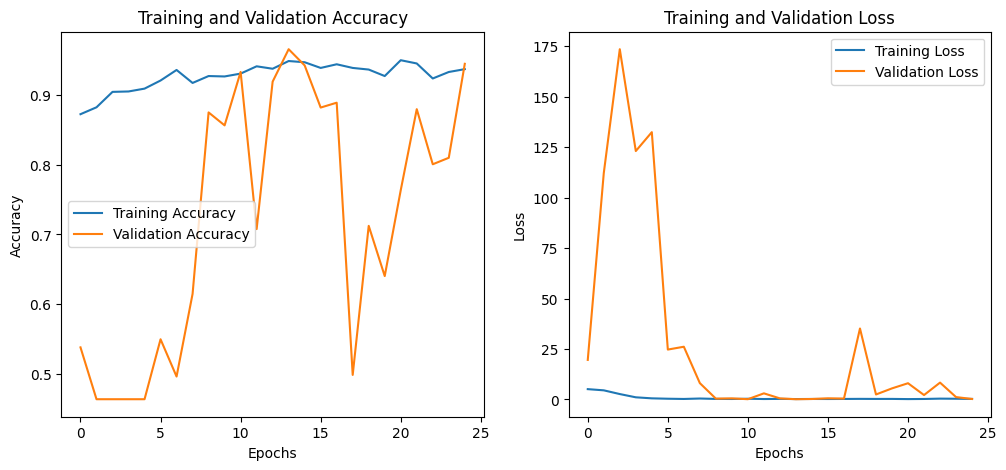

In [ ]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate model performance on training and validation datasets

# Evaluate on training data
train_loss, train_accuracy = model.evaluate(train_gen, verbose=1)
print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(val_gen, verbose=1)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 379ms/step - accuracy: 0.8998 - loss: 0.5740
Training Accuracy: 89.54%
Training Loss: 0.6390
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9738 - loss: 0.1048
Validation Accuracy: 94.43%
Validation Loss: 0.2445


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


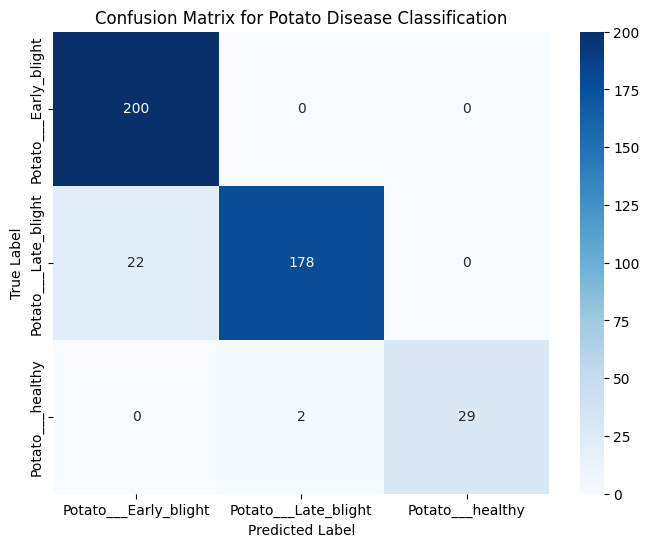


Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       0.90      1.00      0.95       200
 Potato___Late_blight       0.99      0.89      0.94       200
     Potato___healthy       1.00      0.94      0.97        31

             accuracy                           0.94       431
            macro avg       0.96      0.94      0.95       431
         weighted avg       0.95      0.94      0.94       431



In [ ]:
# Confusion Matrix and Class-wise Performance
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get class names (important!)
class_names = list(val_gen.class_indices.keys())

# Reset the validation dataset
val_gen.reset()

# Predict on the entire validation dataset
predictions = model.predict(val_gen, verbose=1)

# Get true and predicted labels
true_labels = val_gen.classes
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix with class names
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Potato Disease Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


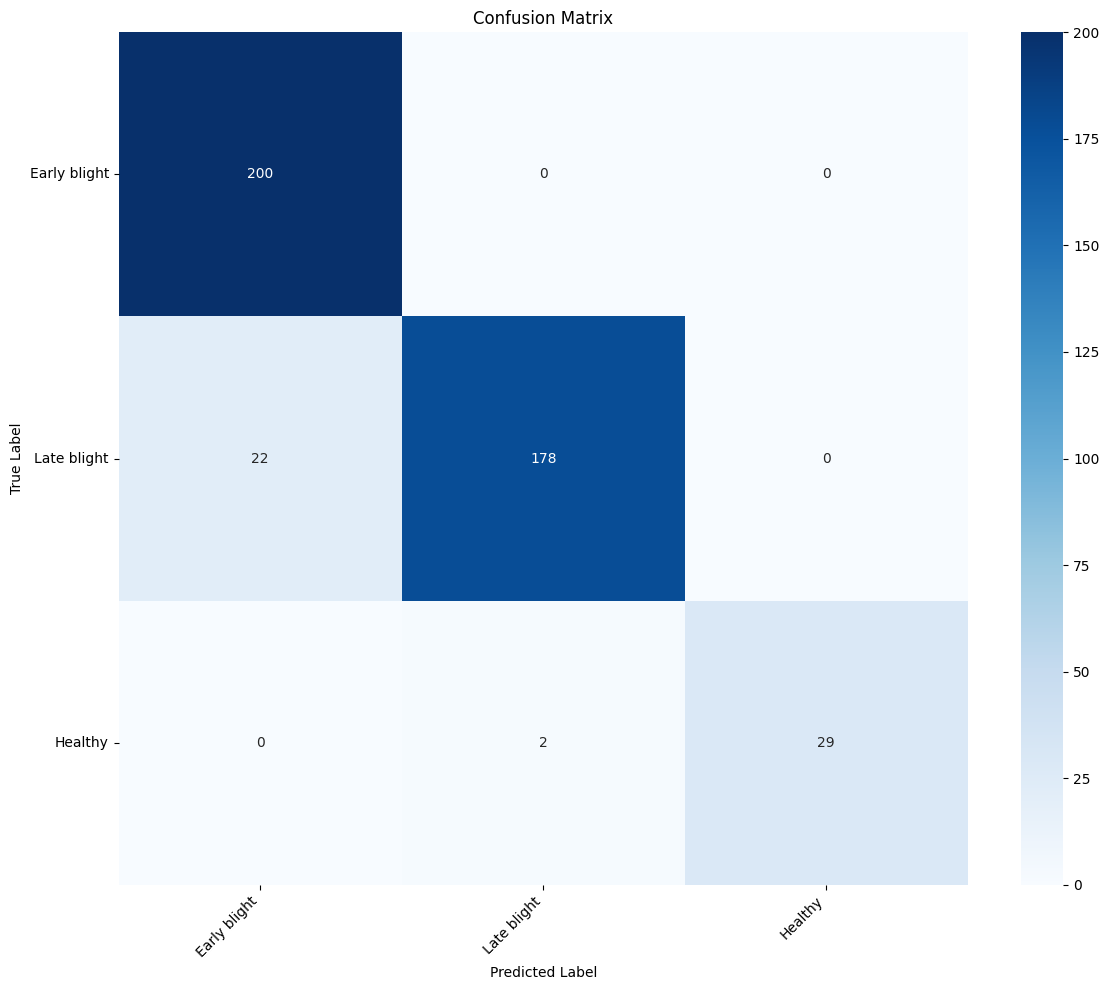

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Reset the validation dataset
val_gen.reset()

# Predict on the entire validation dataset at once
predictions = model.predict(val_gen, verbose=1)

# Get true labels
true_labels = val_gen.classes
predicted_labels = np.argmax(predictions, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create custom class labels
class_names = [
    "Early blight",
    "Late blight",
    "Healthy"
]

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

# Calculate F1 Score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate Precision
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Calculate Recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Calculate ROC-AUC Score
# For ROC-AUC, we need the full prediction probabilities and true labels as one-hot
# First check if there are more than two classes
if len(np.unique(true_labels)) > 2:
    # Multi-class AUC
    true_labels_one_hot = np.eye(len(np.unique(true_labels)))[true_labels]
    roc_auc = roc_auc_score(true_labels_one_hot, predictions, multi_class='ovr')
else:
    # Binary AUC
    roc_auc = roc_auc_score(true_labels, predictions[:,1])

# Print scores
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")


F1 Score: 0.9441
Precision: 0.9489
Recall: 0.9443
ROC-AUC Score: 0.9973


/tmp/ipython-input-1027774132.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


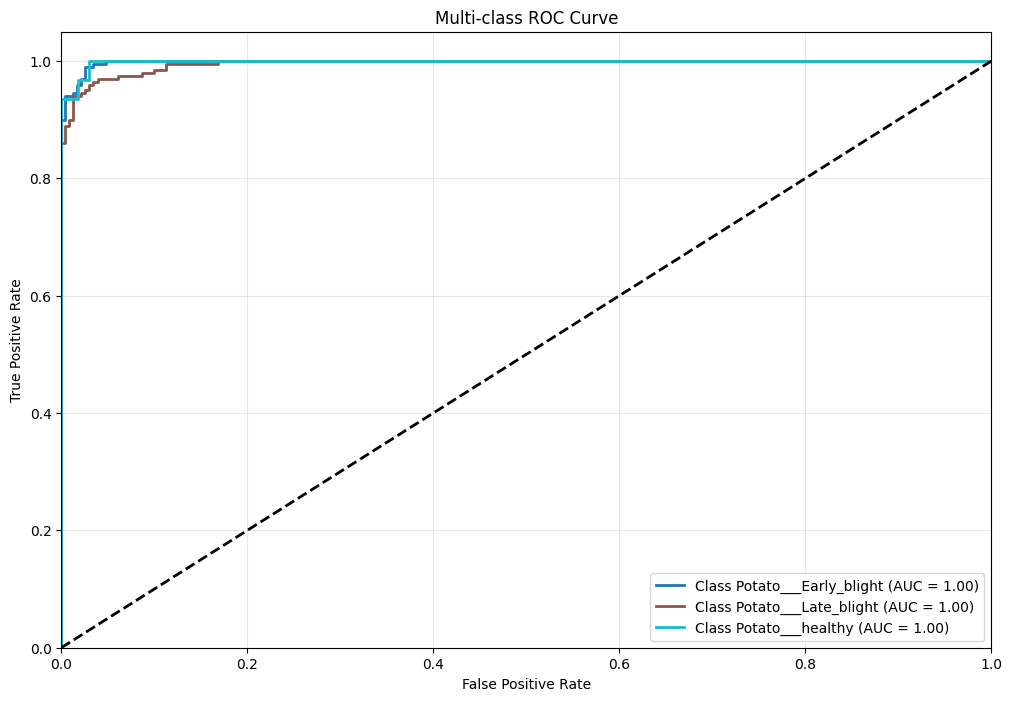

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Number of classes
n_classes = len(val_gen.class_indices) # Get the number of classes from the validation generator

# Binarize the true labels
# Ensure true_labels is a numpy array
true_labels_np = np.array(true_labels)
true_labels_bin = label_binarize(true_labels_np, classes=list(range(n_classes)))

# Calculate FPR, TPR, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
# Adjust colormap based on the actual number of classes
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, color=colors(i),
             label=f'Class {list(val_gen.class_indices.keys())[i]} (AUC = {roc_auc[i]:.2f})') # Use class names for labels

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()